# Motivating examples
This document shows how SparseSC can be used in places where simple difference-in-differences can't.

## Basic setup

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
#%matplotlib inline

try:
    import SparseSC as SC
except ImportError:
    raise RuntimeError("SparseSC is not installed. use 'pip install -e .' from repo root to install in dev mode")

import sys
sys.path.insert(0, ".")
import example_graphs

def simple_summ(ret, Y):
    fit = ret.fit
    V = ret.get_V()[0]
    print("V_pen=%s, W_pen=%s" % (fit.fitted_v_pen, fit.fitted_w_pen))
    print("V=%s" % V)
    print("Treated weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[0,49], fit.sc_weights[0,99], sum(fit.sc_weights[0,:])))
    print("Sim Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[1,49], fit.sc_weights[1,99], sum(fit.sc_weights[1,:])))
    print("Uns Con weights: sim=%s, uns=%s, sum=%s" % (fit.sc_weights[51,49], fit.sc_weights[51,99], sum(fit.sc_weights[51,:])))
    Y_sc = fit.predict(Y)
    print("Treated diff: %s" % (Y - Y_sc)[0,:])


In [3]:
#make sure the results are the same each time we run
random.seed(12345) 
np.random.seed(12345)

Setup common data parameters

In [4]:
N1,N0_sim,N0_not = 2,50,50
N0 = N0_sim + N0_not
N=N1+N0
treated_units = range(N1)
control_units = list(set(range(N)) - set(treated_units))
T0,T1 = 5, 5
T=T0+T1
unit_treatment_periods = np.full((N), -1)
unit_treatment_periods[treated_units] = T0
proto_te = np.hstack((np.zeros((1,T0)), np.full((1,T0), 2)))

## Differential Trends

In [5]:
proto_sim = np.array(range(0,T,1),ndmin=2)
proto_not = np.array(range(0,2*T,2),ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not)+ \
    np.hstack((np.zeros((N0_sim,T0)),np.random.normal(0,.4,(N0_sim,T1))))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc32f99b0>)

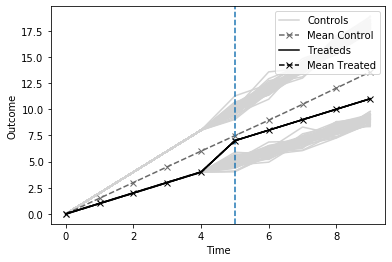

In [6]:
example_graphs.raw(Y, treated_units, control_units, T0)

Analyze

In [7]:
unit_treatment_periods = np.full((N), np.nan)
unit_treatment_periods[treated_units[0]] = T0
      
ret = SC.estimate_effects(Y, unit_treatment_periods, max_n_pl=200) #Do fast
simple_summ(ret, Y)

V_pen=0.000791049380656, W_pen=1e-05
V=[  0.          15.88477448   0.           0.           0.        ]
Treated weights: sim=0.007928681239, uns=0.00595637258089, sum=0.702181372197
Sim Con weights: sim=0.00799999991082, uns=0.00600000005754, sum=0.699999998382
Uns Con weights: sim=0.00799999991082, uns=0.00600000005754, sum=0.699999998382
Treated diff: [  0.00000000e+00  -1.24163302e-09  -2.48326604e-09  -3.72490350e-09
  -4.96653207e-09   2.00286864e+00   2.02434790e+00   2.00439243e+00
   1.96676028e+00   1.93918985e+00]


Visualize

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc8037ba8>)

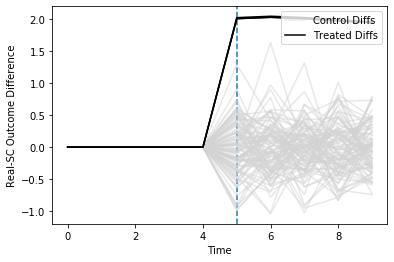

In [8]:
example_graphs.diffs_plot(ret.Y - ret.get_sc(), treated_units, control_units, T0)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc8246470>)

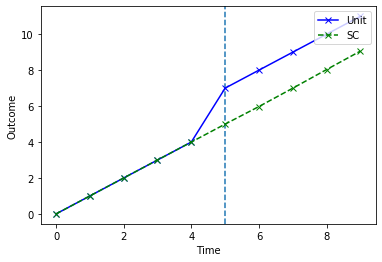

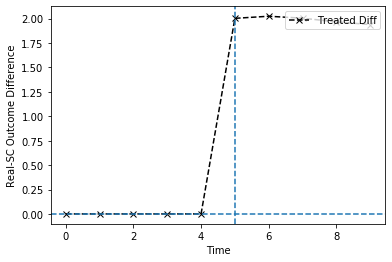

In [9]:
example_graphs.sc_raw(ret, T0, treated_units[0])
#example_graphs.sc_diff(ret, T0, treated_units[0]) #same as te when just 1
example_graphs.te_plot(ret, T0)

## Different cycles 

In [10]:
proto_sim = np.array([0,2,1,3,2,4,3,5,4,6],ndmin=2)
proto_not = np.array([0,1,2,6,3,4,5,6,10,7],ndmin=2)
proto_tr  = proto_sim + proto_te
Y1 = np.matmul(np.ones((N1,1)), proto_tr)
Y0_sim = np.matmul(np.ones((N0_sim,1)), proto_sim) + \
    np.random.normal(0,.3,(N0_sim,T))
Y0_not = np.matmul(np.ones((N0_not,1)), proto_not) + \
    np.random.normal(0,.3,(N0_sim,T))
Y = np.vstack((Y1,Y0_sim,Y0_not))

Motivation: Treated unit does not look like a simple average of controls

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc82daa58>)

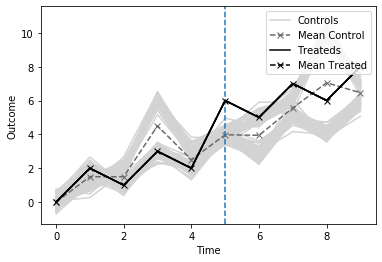

In [11]:
example_graphs.raw(Y, treated_units, control_units, T0)

Analyze

In [12]:
unit_treatment_periods = np.full((N), np.nan)
unit_treatment_periods[treated_units[0]] = T0
      
ret = SC.estimate_effects(Y, unit_treatment_periods, max_n_pl=200)
simple_summ(ret, Y)

V_pen=0.0047778012479, W_pen=0.744380301325
V=[ 0.21687186  0.53863296  0.74655992  1.50121362  0.40128371]
Treated weights: sim=0.0173286350602, uns=0.00118480867392, sum=0.977126772906
Sim Con weights: sim=0.0176559982357, uns=0.00122185749239, sum=0.976590775574
Uns Con weights: sim=0.0137861024852, uns=0.00158792445747, sum=0.8530973997
Treated diff: [  7.86100579e-03   1.26472063e-02  -3.88972229e-03  -7.85369861e-04
  -7.97409241e-04   2.10825916e+00   2.06235414e+00   1.94016069e+00
   1.78558656e+00   2.11894388e+00]


Visualize

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc82b1908>)

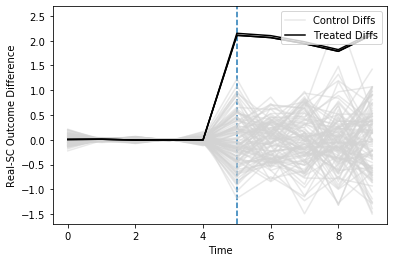

In [13]:
example_graphs.diffs_plot(ret.Y - ret.get_sc(), treated_units, control_units, T0)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1efc8ed11d0>)

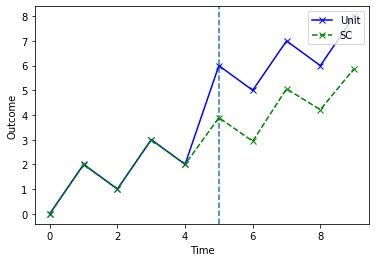

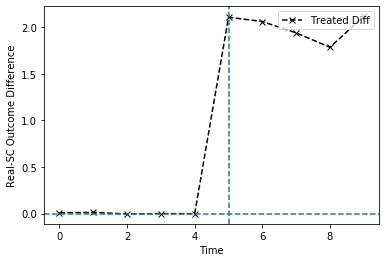

In [14]:
example_graphs.sc_raw(ret, T0, treated_units[0])
#example_graphs.sc_diff(ret, T0, treated_units[0]) #same as te when just 1
example_graphs.te_plot(ret, T0)